In [14]:
%matplotlib inline
import numpy as np
import pathlib
import matplotlib.pyplot as plt

log_path = pathlib.Path('log/davis/swing/decompose_v4/renders-runtime/00100000/runtime_eval/model_out')
files = list(sorted(log_path.glob('*.npy')))
np.set_printoptions(suppress=True)
ID = 0
OUT = np.load(str(files[ID]), allow_pickle=True).item()

files

[PosixPath('log/davis/swing/decompose_v4/renders-runtime/00100000/runtime_eval/model_out/00000.npy'),
 PosixPath('log/davis/swing/decompose_v4/renders-runtime/00100000/runtime_eval/model_out/00029.npy'),
 PosixPath('log/davis/swing/decompose_v4/renders-runtime/00100000/runtime_eval/model_out/00059.npy')]

In [15]:
for k in OUT.keys():
    OUT[k] = OUT[k].astype(np.float32)
    
z_vals = OUT['z_vals']
dirs = OUT['dirs']
sigma_d = OUT['sigma_d']
sigma_s = OUT['sigma_s']
eps=1e-10

last_sample_z = 1e10
dists = np.concatenate([ # distance between each sample along a ray
  z_vals[..., 1:] - z_vals[..., :-1],
  np.broadcast_to([last_sample_z], z_vals[..., :1].shape)
], -1)
dists = dists * np.linalg.norm(dirs[..., None, :], axis=-1)

# dynamic component should not use the last sample located at infinite far away plane
# this allows rays on empty dynamic component to not terminate 
dists_d = np.concatenate([ 
    z_vals[..., 1:] - z_vals[..., :-1],
    np.broadcast_to([1e-19], z_vals[..., :1].shape)
], -1)
dists_d = dists_d * np.linalg.norm(dirs[..., None, :], axis=-1)

alpha_d = (1.0 - np.exp(-sigma_d * dists_d))
alpha_s = (1.0 - np.exp(-sigma_s * dists))
alpha_both = (1.0 - np.exp(-(sigma_d * dists_d + sigma_s * dists)))
# Prepend a 1.0 to make this an 'exclusive' cumprod as in `tf.math.cumprod`.
Ts = np.concatenate([
  np.ones_like(alpha_both[..., :1], alpha_both.dtype),
  np.cumprod(1.0 - alpha_both[..., :-1] + eps, axis=-1),
], axis=-1)

weights_d = alpha_d * Ts
weights_s = alpha_s * Ts
OUT.keys()

dict_keys(['acc', 'blendw', 'depth', 'dirs', 'dists', 'extra_rgb_blendw', 'extra_rgb_dynamic', 'extra_rgb_mask', 'extra_rgb_static', 'med_depth', 'med_points', 'rgb', 'sigma_d', 'sigma_s', 'z_vals'])

In [5]:
k=5
0.5 ** (1/k)

0.8705505632961241

<IPython.core.display.Javascript object>


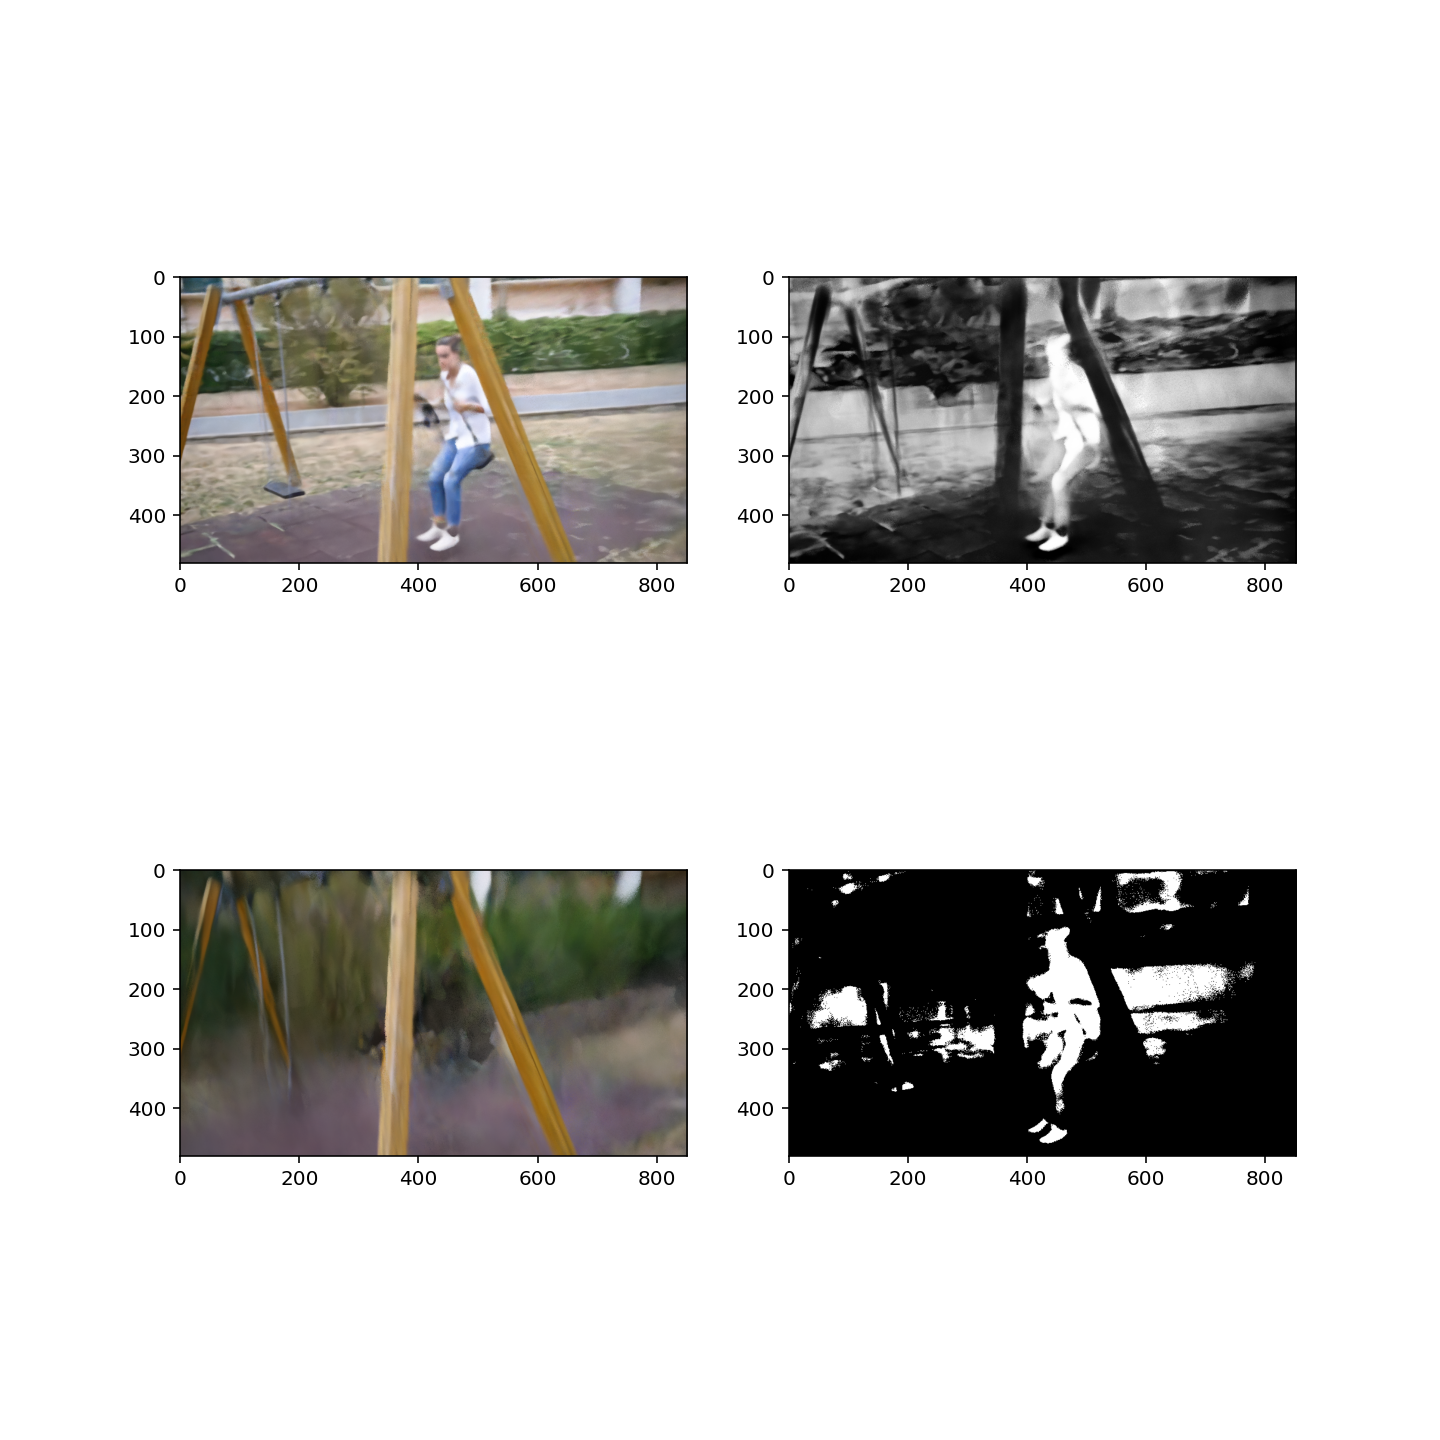

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [16]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,10]
fig, ax = plt.subplots(nrows=2, ncols=2)

k = 2.5

ax[0,0].imshow(OUT['rgb'])
ax[0,1].imshow(OUT['extra_rgb_blendw'])
ax[1,0].imshow(OUT['extra_rgb_static'])
# ax[1,1].imshow(OUT['extra_rgb_mask'])
ax[1,1].imshow(np.where(OUT['extra_rgb_blendw'] > (0.5 ** (1/k)), 1., 0.))
plt.show()

In [17]:
# Note that pixel is obtained by rgb[y,x]
x, y = [707,186]
OUT['extra_rgb_blendw'][y,x]

array([0.7949219, 0.7949219, 0.7949219], dtype=float32)

In [18]:
OUT['blendw'][y,x]

array([0.10375977, 0.07159424, 0.06341553, 0.0581665 , 0.05786133,
       0.05731201, 0.05664062, 0.05630493, 0.05487061, 0.04431152,
       0.03790283, 0.03457642, 0.03213501, 0.03878784, 0.04345703,
       0.04412842, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [13]:
alpha_d[y,x] / np.clip(alpha_d[y,x] + alpha_s[y,x], 1e-19, 100)

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
alpha_s[y,x]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01753743, 0.05415384, 0.00734819,
       0.03509263, 0.03122346, 0.00845511, 0.02156391, 0.02372808,
       0.03830644, 0.02080364, 0.00235232, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

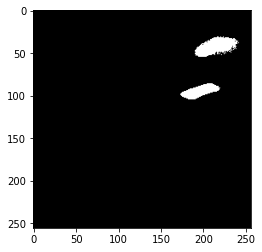

In [31]:
%matplotlib inline
plt.imshow(np.where(OUT['extra_rgb_blendw'] > 0.25, 1., 0.) )